In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.7 MB/s eta 0:00:00


In [2]:
!pip install nltk

In [3]:
import os
import pandas as pd
import numpy as np
import torch
from transformers import DistilBertTokenizer, AutoTokenizer, ConvBertTokenizer, BertTokenizer
from torch import nn
from transformers import DistilBertModel, AutoModel, BertModel
from torch.optim import Adam
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
stopwordSet = set(stopwords.words('turkish'))

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
df = pd.read_excel("/content/drive/MyDrive/lemmatized-cleaned-cased.xlsx")
df

,Unnamed: 0,title,label,num_word,avg_len_word,lemmatized,cleaned,cleaned_cased
0,0,Akıllı telefon bağımlılığı son dönemde dünya ç...,0,21,6,akıl telefon bağımlı son döne dünya çap milyon...,akıllı telefon bağımlılığı son dönemde dünya ç...,Akıllı telefon bağımlılığı son dönemde dünya ç...
1,1,Küresel akıllı telefon satışları beklentilerin...,0,9,7,küre akıl telefon satmak beklenti üst çıkmak b...,küresel akıllı telefon satışları beklentilerin...,Küresel akıllı telefon satışları beklentilerin...
2,2,Apple uygun fiyatlı bir iPad modeli geliştiriyor!,0,7,6,uygun fiyat bir mode geliştirmek,apple uygun fiyatlı bir ipad modeli geliştiriyor,Apple uygun fiyatlı bir iPad modeli geliştiriyor
3,3,Tesla dünyanın en büyük lityum iyon pilini çal...,0,8,5,dünya büyük lityum iyon pil çalışmak,tesla dünyanın büyük lityum iyon pilini çalışt...,Tesla dünyanın büyük lityum iyon pilini çalışt...
4,4,"Drone ile sipariş teslimatı, özellikle Amazon ...",0,13,6,drone sipariş teslimat özellikle dev yapmak ça...,drone sipariş teslimatı özellikle amazon devle...,Drone sipariş teslimatı özellikle Amazon devle...
...,...,...,...,...,...,...,...,...
4886,4886,Takımdan Ayrı Düz Koşu Yapan Futbolcu Ortadan ...,1,8,5,takı ayrı düz koşu yapan futbol orta kaybolmak,takımdan ayrı düz koşu yapan futbolcu ortadan ...,Takımdan Ayrı Düz Koşu Yapan Futbolcu Ortadan ...
4887,4887,"Kameraya ""5 İşareti"" Yapan Taraftarlar Stada A...",1,7,7,kamera işaret yapan taraftar stat alınmak,kameraya i̇şareti yapan taraftarlar stada alın...,Kameraya İşareti Yapan Taraftarlar Stada Alınm...
4888,4888,"Hentbol Federasyonu'ndan Sert Çıkış: ""Utanılac...",1,8,7,ndan sert çıkış utanmak bir iş yapmak,hentbol federasyonu ndan sert çıkış utanılacak...,Hentbol Federasyonu ndan Sert Çıkış Utanılacak...
4889,4889,Deplasman Röportaj Yönetmeliğine Uymayan Futbo...,1,8,6,deplasman röportaj yönetmelik uymak futbol maç...,deplasman röportaj yönetmeliğine uymayan futbo...,Deplasman Röportaj Yönetmeliğine Uymayan Futbo...


In [5]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.7*len(df)), int(.9*len(df))])
df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)
df_test.reset_index(inplace=True)

print(len(df_train),len(df_val), len(df_test))

3423 978 490


In [6]:
#tokenizer = AutoTokenizer.from_pretrained("dbmdz/convbert-base-turkish-mc4-uncased")
#tokenizer = AutoTokenizer.from_pretrained("dbmdz/electra-base-turkish-cased-discriminator")
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = df['label']
        self.texts = [tokenizer(text,
                               padding='max_length',max_length=128,
                                return_tensors="pt") for text in df['cleaned']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [7]:
bert_input = tokenizer(df.cleaned[2999],padding='max_length',  max_length=128, return_tensors="pt")
example_text = tokenizer.decode(bert_input.input_ids[0])

print(bert_input)

{'input_ids': tensor([[  101, 61464, 10180, 45393, 11498, 13306, 26690, 10593, 23429, 10142,
         20754, 13126, 26690, 10112, 10610, 10127, 59526, 11793, 25275, 10111,
         56246, 10142, 19163,   167, 11914, 67381, 16651, 21936, 94349, 12577,
         11733, 11044, 23406, 14017, 37180, 77777, 91654, 26319, 26152,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [ ]:
from transformers import AutoModelWithLMHead
class ElectraClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(ElectraClassifier, self).__init__()

        self.electra = AutoModelWithLMHead.from_pretrained("dbmdz/electra-base-turkish-cased-discriminator")
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)

    def forward(self, input_id, mask):

        outputs = self.electra(input_ids=input_id, attention_mask=mask)
        pooled_output = outputs[0][:, 0, :]  # Use the first token's representation
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)

        return linear_output

In [ ]:
from transformers import ConvBertModel, ConvBertConfig

class ConvBertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(ConvBertClassifier, self).__init__()

        self.convbert = ConvBertModel.from_pretrained('microsoft/conversationalbert-base-multilingual-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_id, mask):
        outputs = self.convbert(input_ids=input_id, attention_mask=mask)
        pooled_output = outputs[0][:, 0, :]  # Use the first token's representation
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.sigmoid(linear_output)
        return final_layer

In [8]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained("bert-base-multilingual-uncased")
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.GELU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = nn.GELU()(linear_output)

        return final_layer

In [9]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion, lr, batch
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/best_model_{}_batch_{}.pth'.format(str(batch), str(lr)))

In [10]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, lr, batch):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/accuracy_{}_batch_{}.png'.format(str(batch), str(lr)))

    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/loss_{}_batch_{}.png'.format(str(batch), str(lr)))

In [11]:
def train(model, train_data, val_data, learning_rate, epochs, batch):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    save_best_model = SaveBestModel()

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()
    train_loss_arr, valid_loss_arr = [], []
    train_acc_arr, valid_acc_arr = [], []
    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                #print(train_label)
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            train_loss_arr.append(round(total_loss_train / len(train_data),3))
            valid_loss_arr.append(round(total_loss_val / len(val_data),3))
            train_acc_arr.append(round(total_acc_train / len(train_data),3))
            valid_acc_arr.append(round(total_acc_val / len(val_data),3))
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            valid_epoch_loss = round(total_loss_val / len(val_data),3)
            save_best_model(
                            valid_epoch_loss, epoch_num + 1, model, optimizer, criterion, learning_rate, batch)
    save_plots(train_acc_arr, valid_acc_arr, train_loss_arr, valid_loss_arr, learning_rate, batch)

100%|██████████| 214/214 [01:23<00:00,  2.58it/s]


Epochs: 1 | Train Loss:  0.040                 | Train Accuracy:  0.662                 | Val Loss:  0.035                 | Val Accuracy:  0.791

Best validation loss: 0.035

Saving best model for epoch: 2



100%|██████████| 214/214 [01:23<00:00,  2.57it/s]


Epochs: 2 | Train Loss:  0.031                 | Train Accuracy:  0.823                 | Val Loss:  0.029                 | Val Accuracy:  0.833

Best validation loss: 0.029

Saving best model for epoch: 3



100%|██████████| 214/214 [01:23<00:00,  2.57it/s]


Epochs: 3 | Train Loss:  0.024                 | Train Accuracy:  0.881                 | Val Loss:  0.023                 | Val Accuracy:  0.871

Best validation loss: 0.023

Saving best model for epoch: 4



100%|██████████| 214/214 [01:23<00:00,  2.58it/s]


Epochs: 4 | Train Loss:  0.017                 | Train Accuracy:  0.922                 | Val Loss:  0.019                 | Val Accuracy:  0.895

Best validation loss: 0.019

Saving best model for epoch: 5



100%|██████████| 214/214 [01:23<00:00,  2.58it/s]


Epochs: 5 | Train Loss:  0.013                 | Train Accuracy:  0.946                 | Val Loss:  0.021                 | Val Accuracy:  0.881


100%|██████████| 214/214 [01:22<00:00,  2.59it/s]


Epochs: 6 | Train Loss:  0.010                 | Train Accuracy:  0.962                 | Val Loss:  0.018                 | Val Accuracy:  0.900

Best validation loss: 0.018

Saving best model for epoch: 7



100%|██████████| 214/214 [01:22<00:00,  2.59it/s]


Epochs: 7 | Train Loss:  0.008                 | Train Accuracy:  0.974                 | Val Loss:  0.018                 | Val Accuracy:  0.905


100%|██████████| 214/214 [01:22<00:00,  2.60it/s]


Epochs: 8 | Train Loss:  0.006                 | Train Accuracy:  0.980                 | Val Loss:  0.018                 | Val Accuracy:  0.903


100%|██████████| 214/214 [01:22<00:00,  2.59it/s]


Epochs: 9 | Train Loss:  0.005                 | Train Accuracy:  0.984                 | Val Loss:  0.020                 | Val Accuracy:  0.901


100%|██████████| 214/214 [01:22<00:00,  2.60it/s]


Epochs: 10 | Train Loss:  0.004                 | Train Accuracy:  0.989                 | Val Loss:  0.019                 | Val Accuracy:  0.904


100%|██████████| 214/214 [01:22<00:00,  2.60it/s]


Epochs: 11 | Train Loss:  0.004                 | Train Accuracy:  0.990                 | Val Loss:  0.020                 | Val Accuracy:  0.905


100%|██████████| 214/214 [01:22<00:00,  2.60it/s]


Epochs: 12 | Train Loss:  0.003                 | Train Accuracy:  0.990                 | Val Loss:  0.021                 | Val Accuracy:  0.903


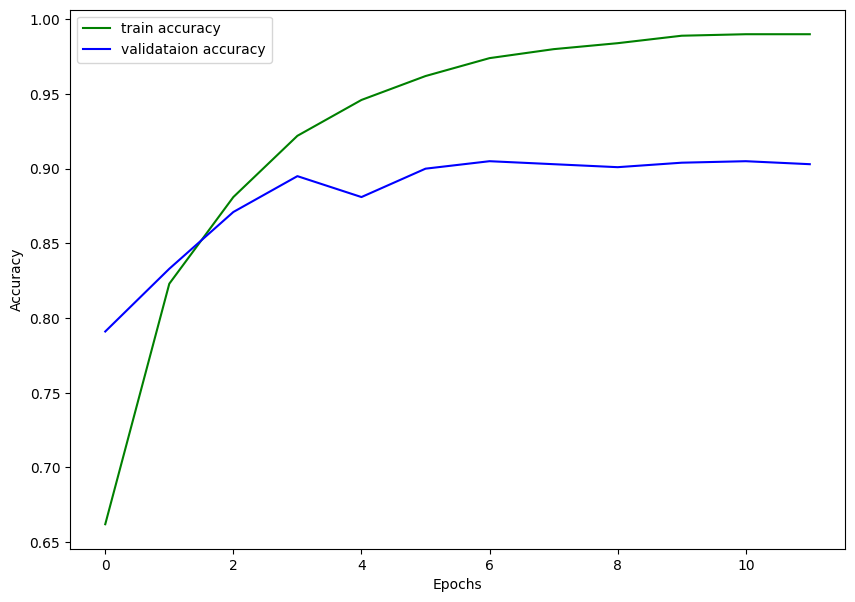

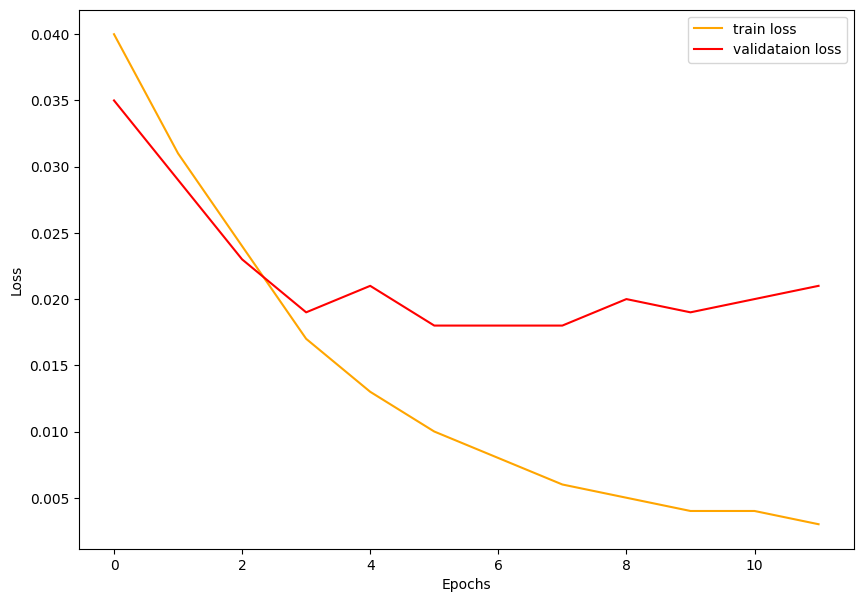

In [13]:
EPOCHS = 12
model = BertClassifier()
#model = ElectraClassifier()
#model = ConvBertClassifier()
LR = 1e-6
batch = 16
train(model, df_train, df_val, LR, EPOCHS, batch)

In [ ]:
"""batch_ = [8, 16, 32, 64]
lr_ = [3e-4, 1e-4, 5e-5]
EPOCHS = 12
model = DistilBertClassifier()

for LR in lr_:
  for batch in batch_:
    train(model, df_train, df_val, LR, EPOCHS, batch)"""

In [15]:
model.bert.save_pretrained("turkish-irony-bert-multilingual-uncased")

In [17]:
tokenizer.save_pretrained("turkish-irony-bert-multilingual-uncased")

('turkish-irony-bert-multilingual-uncased/tokenizer_config.json',
 'turkish-irony-bert-multilingual-uncased/special_tokens_map.json',
 'turkish-irony-bert-multilingual-uncased/vocab.txt',
 'turkish-irony-bert-multilingual-uncased/added_tokens.json')

In [19]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=16)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    predicted_label = []
    actual_label = []
    if use_cuda:
        print("yess")
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

              probs = nn.functional.softmax(output, dim=1)
              output = torch.argmax(probs, dim=1)
              predicted_label += output
              actual_label += test_label
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return predicted_label, actual_label

preds, act = evaluate(model, df_test)

yess
Test Accuracy:  0.888


In [20]:
act = np.array([item.to('cpu') for item in act])
preds = np.array([item.to('cpu') for item in preds])

In [21]:
from sklearn.metrics import classification_report

print(classification_report(act, preds))


              precision    recall  f1-score   support

           0       0.85      0.92      0.88       224
           1       0.92      0.86      0.89       266

    accuracy                           0.89       490
   macro avg       0.89      0.89      0.89       490
weighted avg       0.89      0.89      0.89       490



In [ ]:
"""# load the best model checkpoint
model = DistilBertClassifier()
best_model_cp = torch.load('/content/drive/MyDrive/bert_outputs/distilbert_0.5_dropout_16_batch_30_epoch_1e-6.pth')
best_model_epoch = best_model_cp['epoch']
model.load_state_dict(best_model_cp['model_state_dict'])"""

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [22]:
def leadMyWord(text):
    text = re.sub('[^a-zA-ZğĞüÜşŞıİöÖçÇ]'," ",text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    text = nltk.word_tokenize(text,language='turkish')
    text = [word for word in text if not word in stopwordSet]
    #text = [stemmer.stem(i) for i in text]
    text = " ".join(text)
    return text

def test_sentence(model, text):
  labels = {'Non-Ironic':0,
          'Ironic':1
          }
  # Tokenize sentence
  text = leadMyWord(text)
  texts = tokenizer(text,
                          padding='max_length', max_length = 128, truncation=True,
                          return_tensors="pt")
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  if use_cuda:

    model = model.cuda()

  with torch.no_grad():

        mask = texts['attention_mask'].to(device)
        input_id = texts['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask)

  print(list(labels.keys())[list(labels.values()).index(output.argmax(dim=1).item())])

test_sentence(model, "Dolar Almak İçin Kapalıçarşı'ya Yollanan Merkez Bankası Çalışanları, Halı Satıcısı Olarak İşe Başladı")

Ironic


In [23]:
test_sentence(model, "Yeni aldığım kitaplık harika, hiçbir kitap sığmıyor")

Ironic


In [24]:
test_sentence(model, "Yeni aldığım kitaplık harika, bütün kitaplarım sığıyor")

Ironic
